In [ ]:
!pip install bds_courseware

In [ ]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.0)


In [ ]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 12.5MB/s 


In [ ]:
from spellchecker import SpellChecker

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import re

import warnings 
warnings.filterwarnings('ignore')
from bds_courseware import get_dataset
from bds_courseware.__ids import __datasets 
from bds_courseware._utils import _read_drive_data as read_data
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
import string
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

#Auxiliary methods

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
 
 
cachedStopWords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
def cleaning(text):
  #remove shortening
  text = decontracted(text)
  #set lower register and remove numbers
  text = re.sub(r'\d+', '', text.lower())
  #remove URL
  url = re.compile(r'http(s*)?://\S+|www\.\S+')
  text = url.sub(r'',text)
  #remove HTML
  html = re.compile(r'<.*?>')
  text = html.sub(r'',text)
  #remove punctuations
  text = re.sub(r'[^\w\s]', '', text) 
  #remove whitespaces
  text = re.sub(" +", " ", text)
  # text = text.maketrans('', '', string.punctuation)
  # text = correct_spellings(text)
  return text

In [ ]:
def tokenize(text, stop_words, stem='stemming'):
    min_length = 2
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    if stem == 'stemming':
      tokens = (list(map(lambda token: PorterStemmer().stem(token),
                      words)))
    elif stem == 'lemmatize':
      tokens = [WordNetLemmatizer().lemmatize(word) for word in words]
    else:
      tokens = words
    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(filter(lambda token:
                                  p.match(token) and len(token)>=min_length,tokens))
    return filtered_tokens

In [ ]:
def advanced_tokenize(text, stop_words, stem='stemming'):
    text = cleaning(text)
    return tokenize(text, stop_words, stem=stem)

In [ ]:
def rejoin_words(row):
    joined_words = ( " ".join(row))
    return joined_words

In [ ]:
def get_corpus_statistics(text_series, tokenizer=None, topn=10, n_gram=(1,1)):
    counter = CountVectorizer(ngram_range=n_gram,tokenizer=tokenizer)
    counter.fit(text_series)

    print('size of vocabulary is: {}'.format(len(counter.vocabulary_)))
    bag_of_words = counter.transform(text_series)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in counter.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    print('most_common_words are:')
    display(words_freq[:topn])
    return words_freq

In [ ]:
def correct_spellings(text):
    spell = SpellChecker()
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
def plot_coeffs(coef, feature_names_list, top_features=20):                    # Plot coefficients of words
    
    f, ax = plt.subplots(figsize=(13, 10))
    
    ax.set_title('Most important n-grams for classification', fontsize=20)
    coef = coef.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    ax.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names_list)
    ax.set_yticks(np.arange(2 * top_features))
    ax.set_yticklabels(feature_names[top_coefficients], fontsize=13)
    plt.tight_layout()
    ax.yaxis.grid()
    plt.show()

In [ ]:
def calc_and_plot_rocauc(clf_probs,y_test,clf_name):
  ns_probs = [0 for _ in range(len(y_test))]
  # calculate scores
  ns_auc = roc_auc_score(y_test, ns_probs)
  clf_auc = roc_auc_score(y_test, clf_probs[:, 1])
  # summarize scores
  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('{0}: ROC AUC={1}'.format(clf_name,clf_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  clf_fpr, clf_tpr, _ = roc_curve(y_test, sgd_probs[:,1])
  # plot the roc curve for the model
  plt.figure(figsize=(10, 8))
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(clf_fpr, clf_tpr, marker='.', label=clf_name)
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

In [ ]:
def plot_coeffs_nb(pos_coef, neg_coef, feature_names_list, top_features=20):                    # Plot coefficients of words
    
    f, ax = plt.subplots(figsize=(13, 10))
    
    ax.set_title('Most important n-grams for classification NB', fontsize=20)
    top_positive_coefficients = np.argsort(-pos_coef)[:top_features]
    top_negative_coefficients = np.argsort(neg_coef)[-top_features:]
    top_coefficients = np.hstack([top_negative_coefficients,top_positive_coefficients])
    
    
    colors = ['red' if c < 0 else 'blue' for c in np.hstack([-pos_coef[top_positive_coefficients], neg_coef[top_negative_coefficients]])]
    ax.barh(np.arange(2 * top_features),  np.hstack([neg_coef[top_negative_coefficients],-pos_coef[top_positive_coefficients],]), color=colors)
    feature_names = np.array(feature_names_list)
    ax.set_yticks(np.arange(2 * top_features))
    ax.set_yticklabels(feature_names[top_coefficients], fontsize=13)
    plt.tight_layout()
    ax.yaxis.grid()
    plt.show()

In [ ]:
def plot_coeffs_svc(coef, feature_names_list, top_features=20):                    # Plot coefficients of words
    
    f, ax = plt.subplots(figsize=(13, 10))
    
    ax.set_title('Most important n-grams for classification', fontsize=20)
    # coef = coef.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    ax.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names_list)
    ax.set_yticks(np.arange(2 * top_features))
    ax.set_yticklabels(feature_names[top_coefficients], fontsize=13)
    plt.tight_layout()
    ax.yaxis.grid()
    plt.show()

#Read the data

In [ ]:
data = get_dataset('movie')

KeyboardInterrupt: ignored

In [ ]:
data.info()

In [ ]:
target = data.sentiment

In [ ]:
sns.barplot(target.value_counts().index, target.value_counts().values, alpha=0.8)

Как видим, идеальный баланс в таргете

#Text preprocessing

In [ ]:
data['tokens'] = data.review.apply(lambda x: advanced_tokenize(x, cachedStopWords, 
                                         stem='lemmatize'))

In [ ]:
data.tokens.head()

0    [one, reviewer, mentioned, watching, oz, episo...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, family, little, boy, jake, think, ...
4    [petter, mattei, love, time, money, visually, ...
Name: tokens, dtype: object

In [ ]:
data['processed'] = data.tokens.apply(rejoin_words)

In [ ]:
data.head()

,review,sentiment,tokens,processed
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, mentioned, watching, oz, episo...",one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn...",wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su...",thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ...",basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, mattei, love, time, money, visually, ...",petter mattei love time money visually stunnin...


In [ ]:
get_corpus_statistics(data.processed,topn=30)

size of vocabulary is: 198260
most_common_words are:


[('movie', 98996),
 ('film', 89811),
 ('one', 52677),
 ('like', 39790),
 ('would', 30916),
 ('time', 29391),
 ('good', 28615),
 ('character', 27579),
 ('get', 24435),
 ('even', 24286),
 ('story', 24214),
 ('make', 23556),
 ('see', 23485),
 ('really', 22894),
 ('scene', 20704),
 ('much', 18895),
 ('could', 18488),
 ('well', 18412),
 ('people', 17980),
 ('great', 17803),
 ('bad', 17673),
 ('also', 17491),
 ('show', 16862),
 ('first', 16844),
 ('way', 16535),
 ('thing', 16079),
 ('made', 15405),
 ('think', 15080),
 ('life', 14393),
 ('go', 14286)]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
target = pd.Series(1 if targ=='positive' else 0 for targ in target)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.processed, target, test_size=0.2, shuffle=True, random_state=42)

#SGDClasifier

In [ ]:
my_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (1,2), 
                                   use_idf=True, 
                                   sublinear_tf=True,
                                   norm='l2')),
    ('clf', SGDClassifier())
])

parameters = [{'clf__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5, 10]}]

grid_search = GridSearchCV(my_pipeline, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. clf__alpha=1e-05, total=  20.5s
[CV] clf__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.5s remaining:    0.0s


[CV] ................................. clf__alpha=1e-05, total=  19.9s
[CV] clf__alpha=1e-05 ................................................
[CV] ................................. clf__alpha=1e-05, total=  20.0s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=  19.9s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=  19.6s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=  19.9s
[CV] clf__alpha=0.001 ................................................
[CV] ................................. clf__alpha=0.001, total=  20.2s
[CV] clf__alpha=0.001 ................................................
[CV] ................................. clf__alpha=0.001, total=  19.3s
[CV] clf__alpha=0.001 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  9.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=None,
                                                        min_df=3,
                                                       

In [ ]:
grid_search.best_params_

{'clf__alpha': 0.0001}

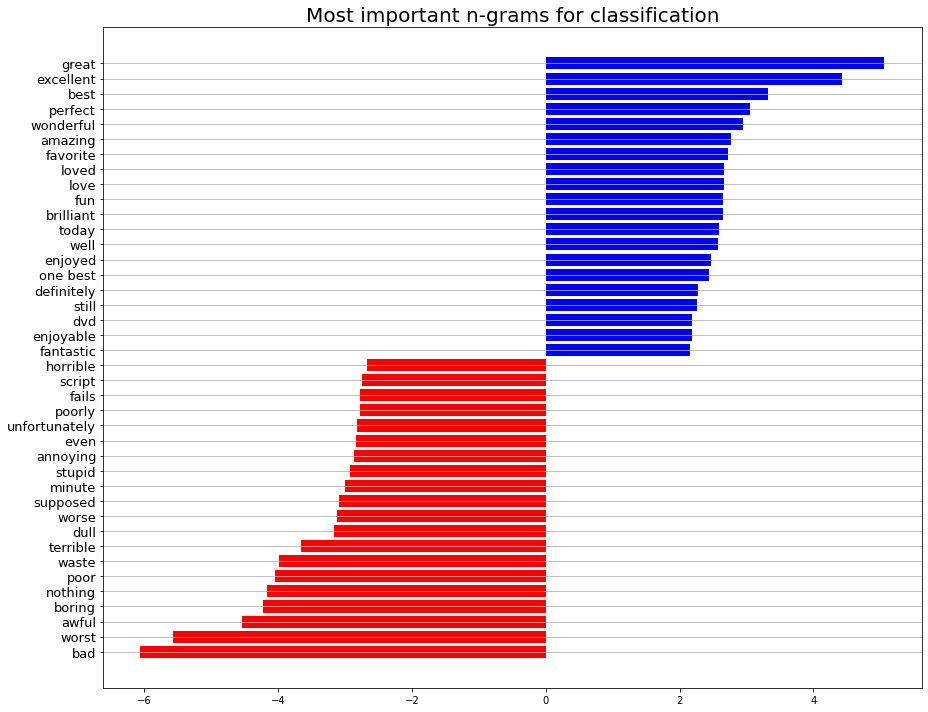

In [ ]:
plot_coeffs(grid_search.best_estimator_.get_params()['steps'][1][1].coef_[0], grid_search.best_estimator_.get_params()['steps'][0][1].get_feature_names())

In [ ]:
clf = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (1,2), 
                                   use_idf=True, 
                                   sublinear_tf=True,
                                   norm='l2')),
    ('clf', SGDClassifier(alpha=0.0001,loss='log'))
])
clf.fit(X_train, y_train)
sgd_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      4961
           1       0.87      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



No Skill: ROC AUC=0.500
SGD: ROC AUC=0.9551965541583549


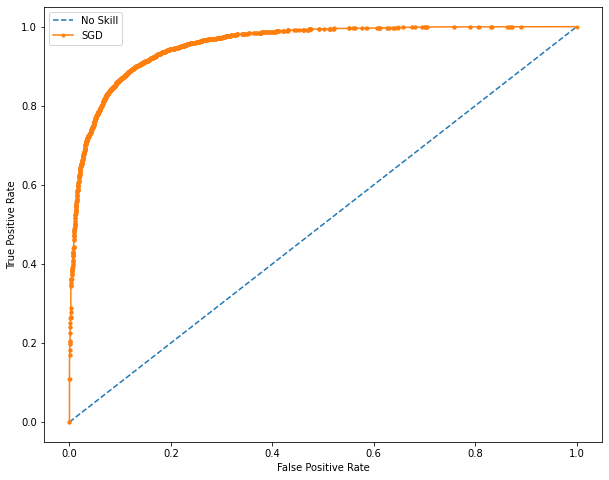

In [ ]:
calc_and_plot_rocauc(sgd_probs,y_test,'SGD')

##SGD with bigrams

Как показал график feature importance ни одна из биграм не попала в топ. Поэтому обучим модель только на биграмах теперь.

In [ ]:
my_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (2,2), 
                                   use_idf=True, 
                                   sublinear_tf=True,
                                   norm='l2')),
    ('clf', SGDClassifier())
])

parameters = [{'clf__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]}]

grid_search = GridSearchCV(my_pipeline, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. clf__alpha=1e-05, total=  15.8s
[CV] clf__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s


[CV] ................................. clf__alpha=1e-05, total=  15.8s
[CV] clf__alpha=1e-05 ................................................
[CV] ................................. clf__alpha=1e-05, total=  16.0s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=  16.0s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=  15.9s
[CV] clf__alpha=0.0001 ...............................................
[CV] ................................ clf__alpha=0.0001, total=  15.8s
[CV] clf__alpha=0.001 ................................................
[CV] ................................. clf__alpha=0.001, total=  15.8s
[CV] clf__alpha=0.001 ................................................
[CV] ................................. clf__alpha=0.001, total=  15.6s
[CV] clf__alpha=0.001 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  4.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=None,
                                                        min_df=3,
                                                       

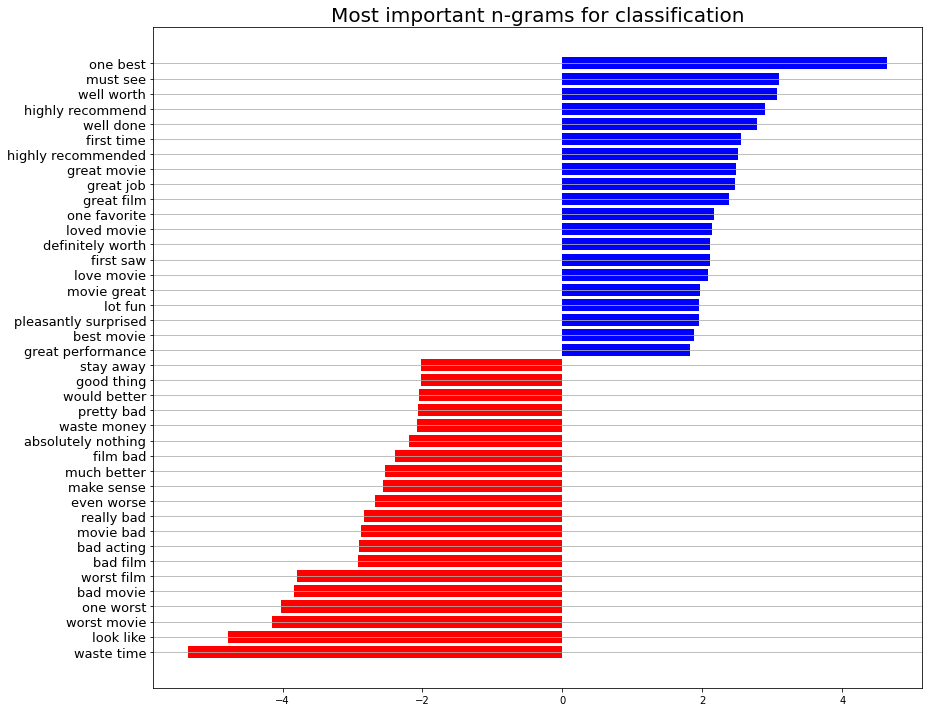

In [ ]:
plot_coeffs(grid_search.best_estimator_.get_params()['steps'][1][1].coef_[0], grid_search.best_estimator_.get_params()['steps'][0][1].get_feature_names())

In [ ]:
clf = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (2,2), 
                                   use_idf=True, 
                                   sublinear_tf=True,
                                   norm='l2')),
    ('clf', SGDClassifier(alpha=0.0001,loss='log'))
])
clf.fit(X_train, y_train)
sgd_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4961
           1       0.84      0.88      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



No Skill: ROC AUC=0.500
SGD: ROC AUC=0.9282462745033409


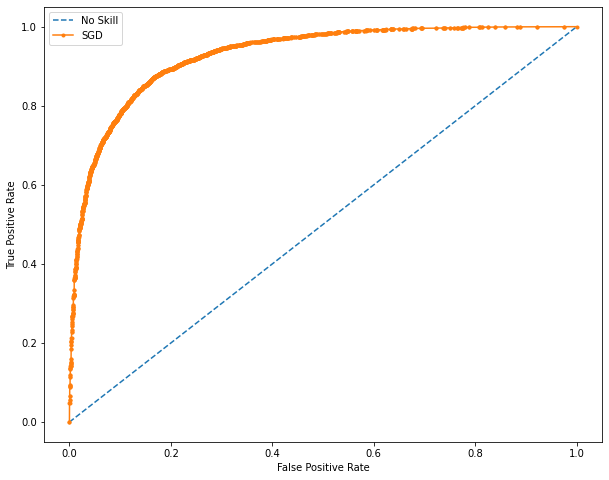

In [ ]:
calc_and_plot_rocauc(sgd_probs,y_test,'SGD')

Как видим, модель обученная на биграммах показал резлуьтат хуже, но не сильно, при этом на графике важности фичей теперь можно увидеть достаточно эмоциональные биграмы.

# Naive Bayes 


##Multinomial NB

Возьмем для начала обычный MultinomialNB, обучим его и посмотрим скор и важность слов. Затем, поскольку в некоторых источниках утверждают, что binary NB лучше справляется с задачей тональности текста, повторим все тоже самое для BernoulliNB и сравним результаты.

In [ ]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

In [ ]:
tuned_parameters = [{'clf__alpha': [0, 0.5, 1.0, 5, 10], 'clf__fit_prior':[True, False]}]

In [ ]:
my_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (1,2), 
                                   use_idf=True, 
                                   sublinear_tf=True,
                                   norm='l2')),
    ('clf', MultinomialNB())
])



grid_search = GridSearchCV(my_pipeline, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=2)


In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] clf__alpha=0, clf__fit_prior=True ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ clf__alpha=0, clf__fit_prior=True, total=  20.5s
[CV] clf__alpha=0, clf__fit_prior=True ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.5s remaining:    0.0s


[CV] ................ clf__alpha=0, clf__fit_prior=True, total=  19.9s
[CV] clf__alpha=0, clf__fit_prior=True ...............................
[CV] ................ clf__alpha=0, clf__fit_prior=True, total=  21.2s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=  20.4s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=  20.0s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=  20.3s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .............. clf__alpha=0.5, clf__fit_prior=True, total=  20.2s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .............. clf__alpha=0.5, clf__fit_prior=True, total=  19.9s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 10.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=None,
                                                        min_df=3,
                                                       

In [ ]:
grid_search.best_params_

{'clf__alpha': 0.5, 'clf__fit_prior': True}

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      4961
           1       0.89      0.89      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

No Skill: ROC AUC=0.500
NB: ROC AUC=0.95716435387929


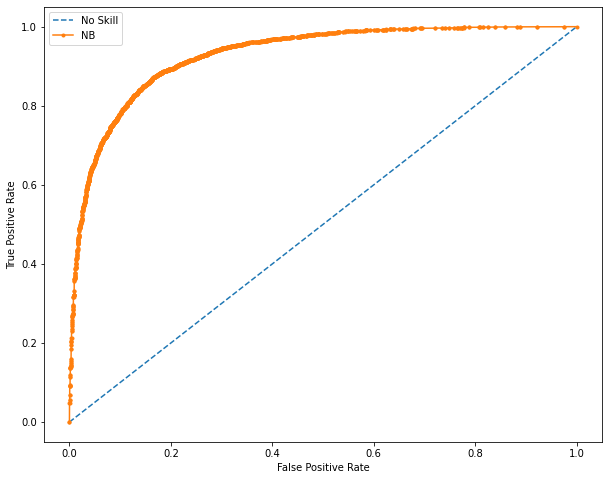

In [ ]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (1,2), 
                             use_idf=True, 
                             sublinear_tf=True,
                             norm='l2')
X_train_vct = vectorizer.fit_transform(X_train)
X_test_vct = vectorizer.transform(X_test)
clf = MultinomialNB(alpha=0.5,fit_prior=True)
clf.fit(X_train_vct, y_train)
nb_probs = clf.predict_proba(X_test_vct)
y_pred = clf.predict(X_test_vct)
print(classification_report(y_test, y_pred))
calc_and_plot_rocauc(nb_probs,y_test,'NB')

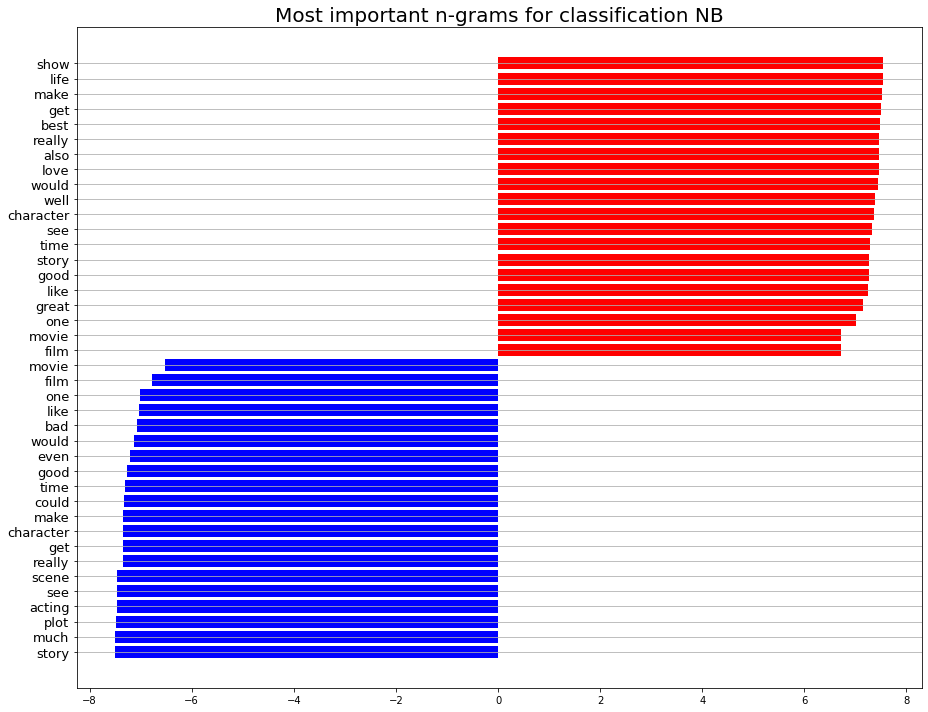

In [ ]:
neg_class_prob = clf.feature_log_prob_[0, :]
pos_class_prob = clf.feature_log_prob_[1, :]

plot_coeffs_nb(pos_class_prob, neg_class_prob, vectorizer.get_feature_names())

##Binary NB

Перед построением модели BernoulliNB, важно вспомнить что он работает с фактом того, есть ли слово в тексте или нет его, поэтому тексты будем векторизовывать через CountVectorizer.

In [ ]:
my_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3, max_df=0.90, ngram_range = (1,2))),
    ('clf', BernoulliNB())
])



grid_search = GridSearchCV(my_pipeline, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] clf__alpha=0, clf__fit_prior=True ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ clf__alpha=0, clf__fit_prior=True, total=  22.4s
[CV] clf__alpha=0, clf__fit_prior=True ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.4s remaining:    0.0s


[CV] ................ clf__alpha=0, clf__fit_prior=True, total=  21.1s
[CV] clf__alpha=0, clf__fit_prior=True ...............................
[CV] ................ clf__alpha=0, clf__fit_prior=True, total=  20.1s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=  20.3s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=  20.1s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=  20.3s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .............. clf__alpha=0.5, clf__fit_prior=True, total=  20.2s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .............. clf__alpha=0.5, clf__fit_prior=True, total=  20.2s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 10.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=None,
                                                        min_df=3,
                                                        n

In [ ]:
grid_search.best_params_

{'clf__alpha': 1.0, 'clf__fit_prior': False}

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4961
           1       0.89      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

No Skill: ROC AUC=0.500
NB: ROC AUC=0.9471824065776164


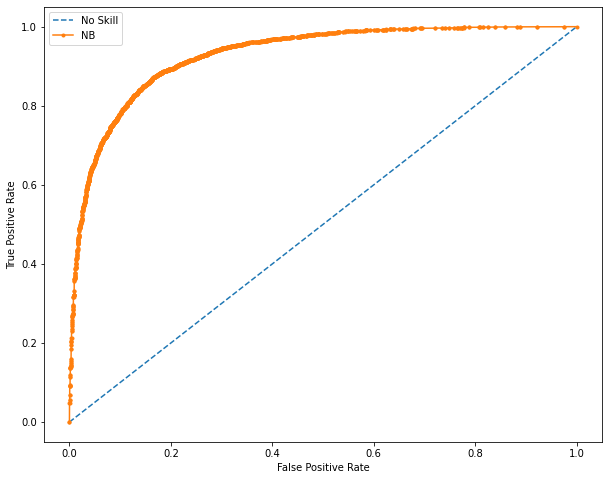

In [ ]:
vectorizer = CountVectorizer(min_df=3, max_df=0.90, ngram_range = (1,2))
X_train_vct = vectorizer.fit_transform(X_train)
X_test_vct = vectorizer.transform(X_test)
clf = BernoulliNB(alpha=1,fit_prior=False)
clf.fit(X_train_vct, y_train)
nb_probs = clf.predict_proba(X_test_vct)
y_pred = clf.predict(X_test_vct)
print(classification_report(y_test, y_pred))
calc_and_plot_rocauc(nb_probs,y_test,'NB')

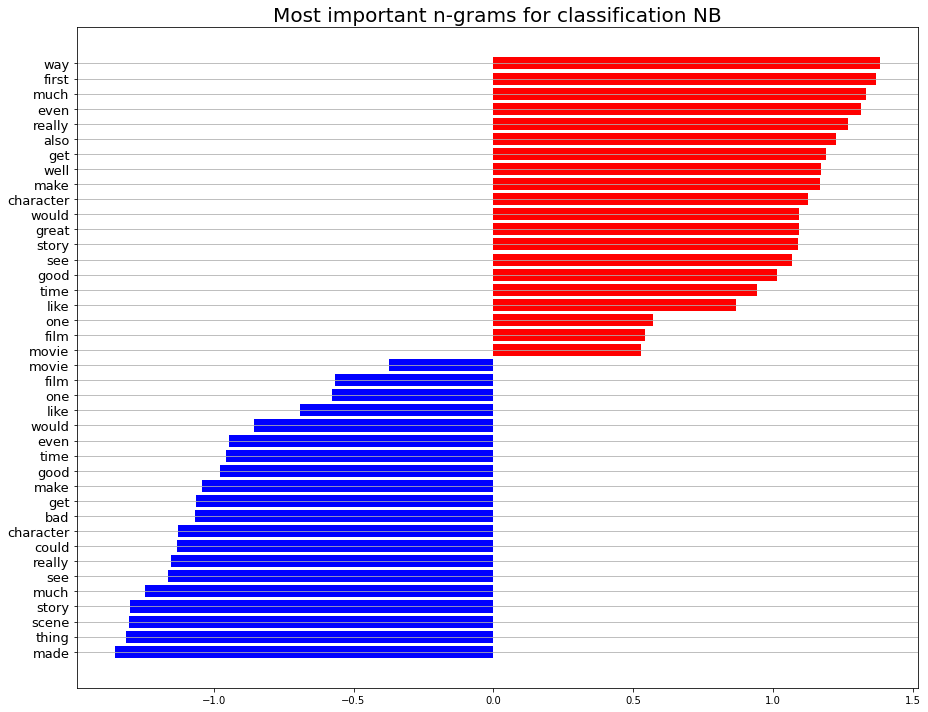

In [ ]:
neg_class_prob = clf.feature_log_prob_[0, :]
pos_class_prob = clf.feature_log_prob_[1, :]

plot_coeffs_nb(pos_class_prob, neg_class_prob, vectorizer.get_feature_names())

##Multinomal NB with bigrams

In [ ]:
tuned_parameters = [{'clf__alpha': [0, 0.5, 1.0], 'clf__fit_prior':[True, False]}]

In [ ]:
my_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (2,2), 
                                   use_idf=True, 
                                   sublinear_tf=True,
                                   norm='l2')),
    ('clf', MultinomialNB())
])



grid_search = GridSearchCV(my_pipeline, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='roc_auc', verbose=2)


In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__alpha=0, clf__fit_prior=True ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ clf__alpha=0, clf__fit_prior=True, total=  17.9s
[CV] clf__alpha=0, clf__fit_prior=True ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s remaining:    0.0s


[CV] ................ clf__alpha=0, clf__fit_prior=True, total=  17.4s
[CV] clf__alpha=0, clf__fit_prior=True ...............................
[CV] ................ clf__alpha=0, clf__fit_prior=True, total=  18.0s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=  17.9s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=  16.7s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=  17.6s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .............. clf__alpha=0.5, clf__fit_prior=True, total=  17.2s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .............. clf__alpha=0.5, clf__fit_prior=True, total=  17.1s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=None,
                                                        min_df=3,
                                                       

In [ ]:
grid_search.best_params_

{'clf__alpha': 1.0, 'clf__fit_prior': True}

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4961
           1       0.88      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

No Skill: ROC AUC=0.500
NB: ROC AUC=0.9524327860107008


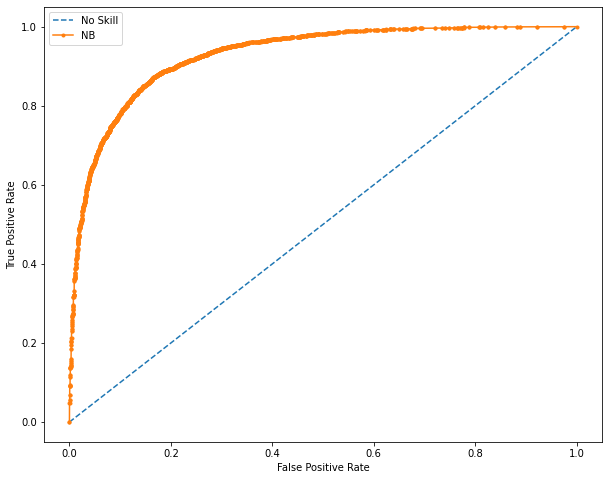

In [ ]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (2,2), 
                             use_idf=True, 
                             sublinear_tf=True,
                             norm='l2')
X_train_vct = vectorizer.fit_transform(X_train)
X_test_vct = vectorizer.transform(X_test)
clf = MultinomialNB(alpha=1,fit_prior=True)
clf.fit(X_train_vct, y_train)
nb_probs = clf.predict_proba(X_test_vct)
y_pred = clf.predict(X_test_vct)
print(classification_report(y_test, y_pred))
calc_and_plot_rocauc(nb_probs,y_test,'NB')

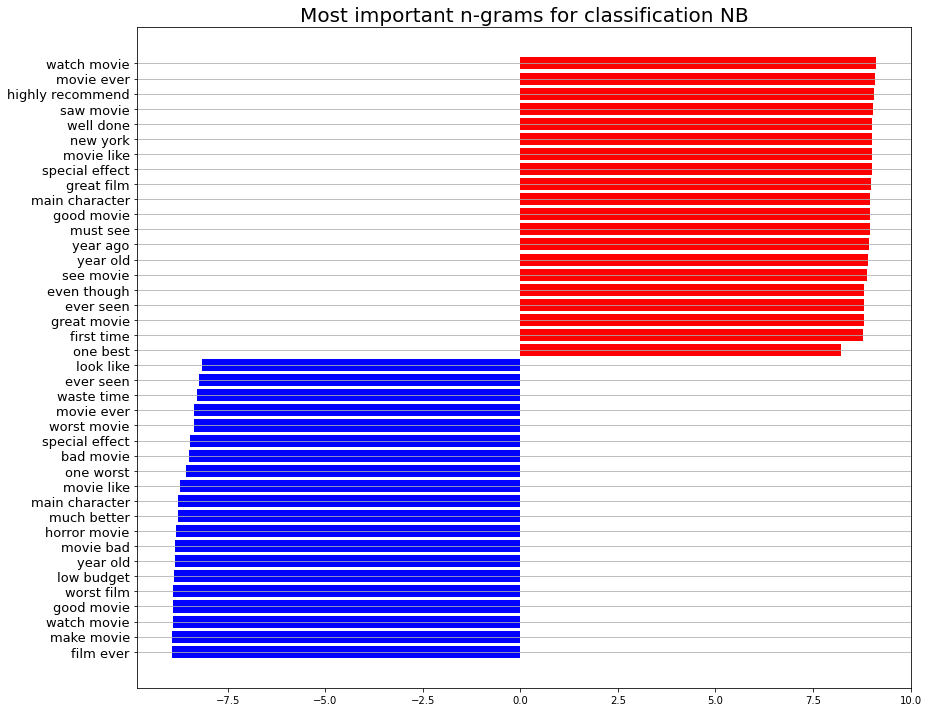

In [ ]:
neg_class_prob = clf.feature_log_prob_[0, :]
pos_class_prob = clf.feature_log_prob_[1, :]

plot_coeffs_nb(pos_class_prob, neg_class_prob, vectorizer.get_feature_names())

##Результаты NB



1.   Согласно метрике ROC-AUC мультиномиальный классификатор показал лучший результат, чем его бинарный аналог.
2.   Если помотреть на feature importance, то можно заметить, что в случае мультиномиального Байеса важные признаки, имеют больший смыслой окрас. Также видно, что в обоих случаях есть слова которые попали в рейтинг важности у обоих таргетов. Для дальнешего исследования можно попробовать удалить эти слова и построить модели без них.
3. Модель на биграмах, показала хороший результат, даже лучше чем BernoulliNB но на feature_importance все также не видно сильных смысловых оттенков.



#SVC

In [ ]:
from sklearn.svm import SVC

Из-за большого объема данных SVC очень долго обучается, поэтому для его обучения будем использовать только униграммы.

In [ ]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (1,1), 
                             use_idf=True, 
                             sublinear_tf=True,
                             norm='l2')
X_train_vct = vectorizer.fit_transform(X_train)
X_test_vct = vectorizer.transform(X_test)

In [ ]:
tuned_parameters = [{'clf__kernel': ['linear'], 'clf__gamma': ['scale'],
                     'clf__C': [1, 10, 100]},]
                  #  {'clf__kernel': ['linear'], 'clf__gamma':['auto'], 'clf__C': [1, 10, 100, 1000]}, ]

In [ ]:
my_pipeline = Pipeline([
    ('clf', SVC(probability=True))
])


grid_search = GridSearchCV(my_pipeline, param_grid=tuned_parameters,
                           cv=StratifiedKFold(2), scoring='roc_auc', verbose=2)

In [ ]:
grid_search.fit(X_train_vct, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] clf__C=1, clf__gamma=scale, clf__kernel=linear ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... clf__C=1, clf__gamma=scale, clf__kernel=linear, total=32.9min
[CV] clf__C=1, clf__gamma=scale, clf__kernel=linear ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 32.9min remaining:    0.0s


[CV] ... clf__C=1, clf__gamma=scale, clf__kernel=linear, total=32.7min
[CV] clf__C=10, clf__gamma=scale, clf__kernel=linear .................
[CV] .. clf__C=10, clf__gamma=scale, clf__kernel=linear, total=64.2min
[CV] clf__C=10, clf__gamma=scale, clf__kernel=linear .................
[CV] .. clf__C=10, clf__gamma=scale, clf__kernel=linear, total=64.2min
[CV] clf__C=100, clf__gamma=scale, clf__kernel=linear ................
[CV] . clf__C=100, clf__gamma=scale, clf__kernel=linear, total=66.6min
[CV] clf__C=100, clf__gamma=scale, clf__kernel=linear ................
[CV] . clf__C=100, clf__gamma=scale, clf__kernel=linear, total=68.5min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 329.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=True, random_state=None,
                                            shrinking=True, tol=0.001,
                                            verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'clf__C': [1, 10, 100], 'clf__gamma': ['scale'],


In [ ]:
grid_search.best_params_

{'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}

In [ ]:
clf = SVC(kernel='linear',C=1,gamma='scale',probability=True)
clf.fit(X_train_vct, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4961
           1       0.89      0.90      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

No Skill: ROC AUC=0.500
SVC: ROC AUC=0.962321187621055


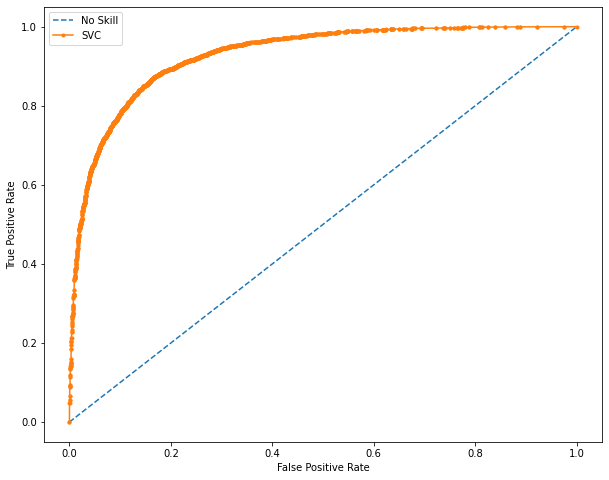

In [ ]:
nb_probs = clf.predict_proba(X_test_vct)
y_pred = clf.predict(X_test_vct)
print(classification_report(y_test, y_pred))
calc_and_plot_rocauc(nb_probs,y_test,'SVC')

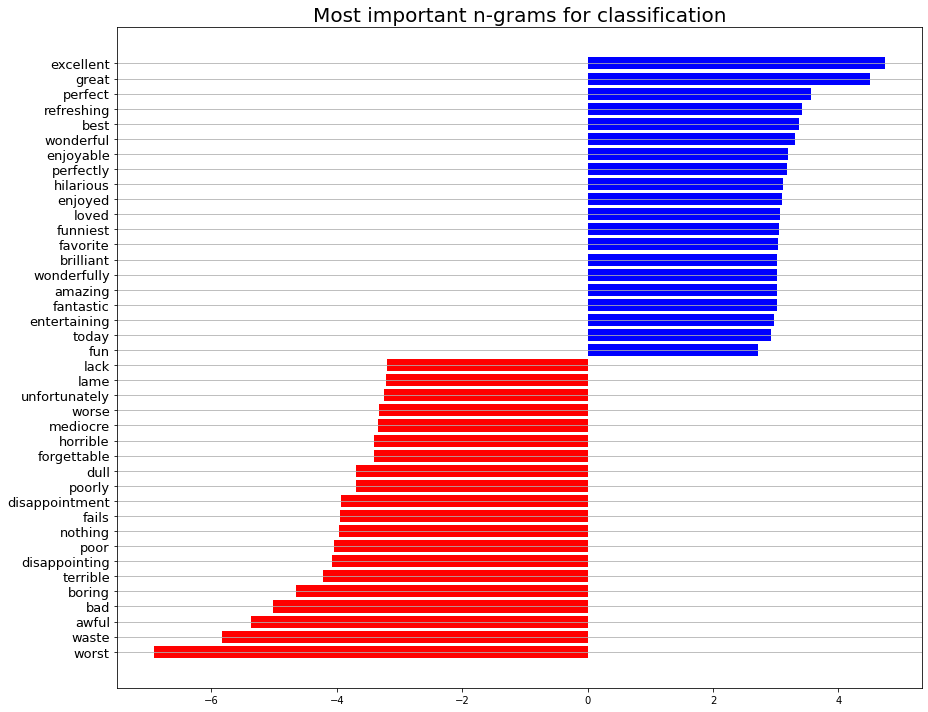

In [ ]:
plot_coeffs_svc(clf.coef_[0].toarray()[0],vectorizer.get_feature_names())

SVC показал лучший результат на метрике AUC-ROC, и на карте значимости n-gram видно что, значимые токины имеют сильную эмоциональную окраску. НО: SVC обучался почти 3 ЧАСА. 3!!!! КАРЛ!!! )))

Поэтому попробуем оставить только 1000 самых важных токенов согласно мере tf-idf.

In [ ]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (1,1), 
                             use_idf=True, 
                             sublinear_tf=True,
                             norm='l2', max_features = 1000)
X_train_vct = vectorizer.fit_transform(X_train)
X_test_vct = vectorizer.transform(X_test)

In [ ]:
clf = SVC(kernel='linear',C=1,gamma='scale',probability=True)
clf.fit(X_train_vct, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4961
           1       0.85      0.88      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

No Skill: ROC AUC=0.500
SVC: ROC AUC=0.9381022141387082


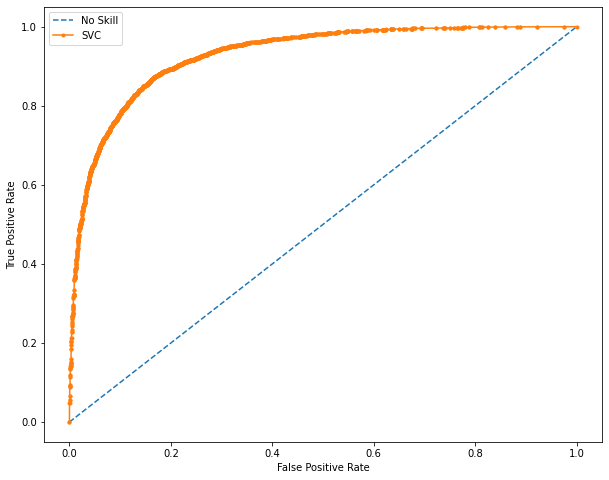

In [ ]:
nb_probs = clf.predict_proba(X_test_vct)
y_pred = clf.predict(X_test_vct)
print(classification_report(y_test, y_pred))
calc_and_plot_rocauc(nb_probs,y_test,'SVC')

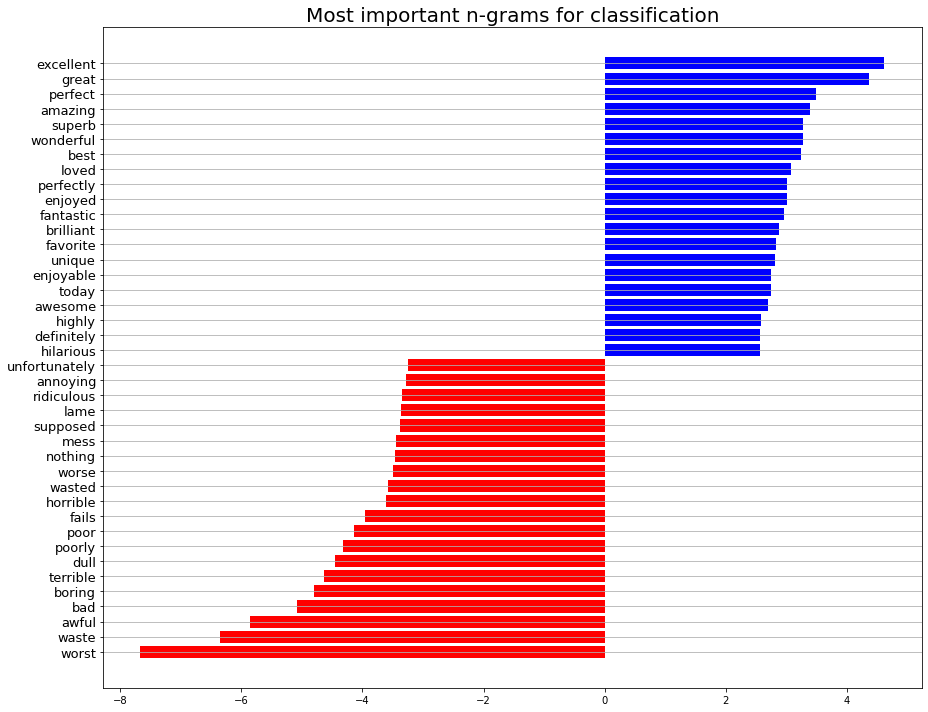

In [ ]:
plot_coeffs_svc(clf.coef_[0].toarray()[0],vectorizer.get_feature_names())

Алгоритм SVM на 1000 признаков показал результат хуже, при этом значимые фичи во многом совпадают, но все равно не полностью.

Теперь оставим только 100 значимых токенов и снова обучим модель

In [ ]:
coef = clf.coef_[0].toarray()[0]
top_features = 100
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
feature_names = np.array(vectorizer.get_feature_names())
name_top_features = feature_names[top_coefficients]

In [ ]:
def filter_features(lst, name_top_features):
  new_lst = [x for x in lst if x in name_top_features]
  return new_lst

In [ ]:
data['sign_tokens'] = data.tokens.apply(lambda x: filter_features(x,name_top_features))
data['sign_processed'] = data.sign_tokens.apply(rejoin_words)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.sign_processed, target, test_size=0.2, shuffle=True, random_state=42)
vectorizer = TfidfVectorizer(min_df=3, max_df=0.90, ngram_range = (1,1), 
                             use_idf=True, 
                             sublinear_tf=True,
                             norm='l2')
X_train_vct = vectorizer.fit_transform(X_train)
X_test_vct = vectorizer.transform(X_test)

In [ ]:
clf = SVC(kernel='linear',C=1,gamma='scale',probability=True)
clf.fit(X_train_vct, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      4961
           1       0.84      0.87      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

No Skill: ROC AUC=0.500
SVC: ROC AUC=0.9277759658897649


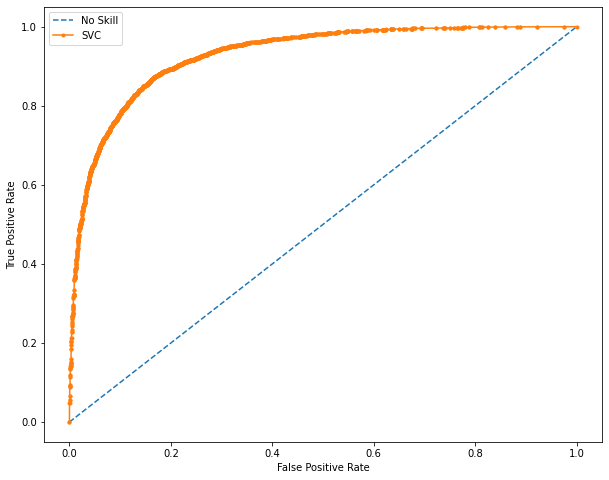

In [ ]:
nb_probs = clf.predict_proba(X_test_vct)
y_pred = clf.predict(X_test_vct)
print(classification_report(y_test, y_pred))
calc_and_plot_rocauc(nb_probs,y_test,'SVC')

Мы получили резлуьтат немногим хуже модели с 1000 самых важных токенов согласно мере tf-idf, но при этом модель обучилась в 5 раз быстрее, поэтому возможно, что при выпуске модели в прод и отсутсвии мощного железа стоит использовать вариант с главными фичами для более быстрого обучения и построения предсказаний.

#Сравнение результатов моделей

1.   MultinominalNB показал результат немногим лучше SGD, при этом feature importance более информативен для SGD.
2.   SVM показал лучший результат и значимые фичи имели большую эмоциональную окраску, но при этом работал существенно дольше дольше, что намного осложняет его использование.
